#  Trader Performance vs Market Sentiment





## 1.Data Preparation

In [80]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [81]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")


In [82]:
trades['date'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True
).dt.normalize()

sentiment['date'] = pd.to_datetime(sentiment['date']).dt.normalize()



In [83]:
df = trades.merge(
sentiment[['date','classification']],
on='date',
how='left'
)

In [84]:
print(df.shape)
print(df['classification'].value_counts())
print(df.isna().sum())

(211224, 18)
classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
date                0
classification      6
dtype: int64


## 2.Feature Engineering

In [85]:
df['size_segment'] = pd.qcut(df['Size USD'],3,labels=['small','medium','large'])

In [86]:
daily_pnl = df.groupby(['Account','date'])['Closed PnL'].sum().reset_index()
daily_pnl.head()


,Account,date,Closed PnL
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1


In [87]:
trade_count = df.groupby(['Account','date']).size().reset_index(name='num_trades')
trade_count.head()


,Account,date,num_trades
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,177
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,68
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,40
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,12
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,27


In [88]:
long_short = df.groupby(['date','Side']).size().unstack(fill_value=0)
long_short['long_short_ratio'] = long_short['BUY'] / (long_short['SELL'] + 1)
long_short.head()


Side,BUY,SELL,long_short_ratio
date,,,
2023-05-01,3,0,3.000000
2023-12-05,7,2,2.333333
2023-12-14,5,6,0.714286
2023-12-15,2,0,2.000000
2023-12-16,3,0,3.000000


In [89]:
trade_freq = df.groupby('Account').size()
freq_map = (trade_freq > trade_freq.median()).astype(int)

df['freq_segment'] = df['Account'].map(freq_map)
df['freq_segment'] = df['freq_segment'].map({0:'low_freq',1:'high_freq'})


In [90]:
df.groupby('classification')['Closed PnL'].mean()


,Closed PnL
classification,
Extreme Fear,34.537862
Extreme Greed,67.892861
Fear,54.290400
Greed,42.743559
Neutral,34.307718


 ## 3.Sentiment Analysis

In [91]:
result = df.groupby(
    ['classification','size_segment'],
    observed=True
)['Closed PnL'].mean().unstack()

result

size_segment,small,medium,large
classification,,,
Extreme Fear,-0.294766,5.780856,86.054507
Extreme Greed,6.694096,28.301795,192.633660
Fear,1.968209,10.389486,139.074587
Greed,2.623613,12.808832,114.320022
Neutral,1.048531,7.159185,101.578799


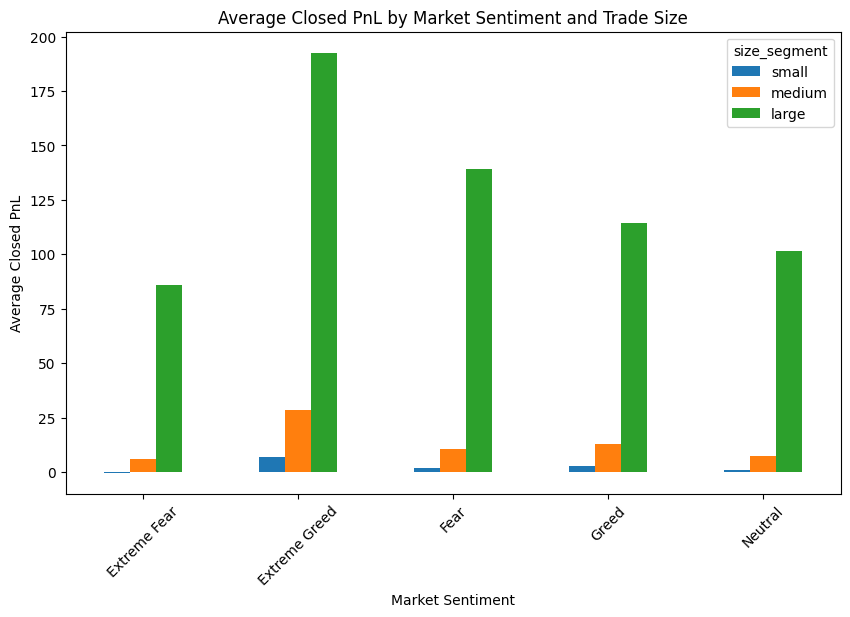

In [92]:
result.plot(kind='bar', figsize=(10,6))

plt.title('Average Closed PnL by Market Sentiment and Trade Size')
plt.ylabel('Average Closed PnL')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.show()


Observation:
Larger trade sizes generate higher PnL across all sentiment regimes.
Extreme Fear negatively impacts small traders, while Extreme Greed shows
the strongest profitability, especially for medium and large trade segments.


In [93]:
df.groupby('classification')['Size USD'].mean().sort_values()


,Size USD
classification,
Extreme Greed,3112.251565
Neutral,4782.732661
Extreme Fear,5349.731843
Greed,5736.884375
Fear,7816.109931


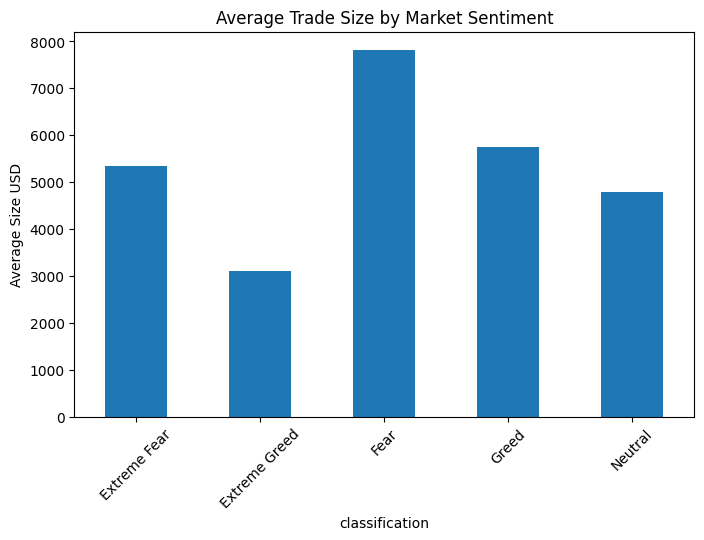

In [94]:
df.groupby('classification')['Size USD'].mean().plot(kind='bar', figsize=(8,5))
plt.title('Average Trade Size by Market Sentiment')
plt.ylabel('Average Size USD')
plt.xticks(rotation=45)
plt.show()


## 4.Behavioral Segmentation

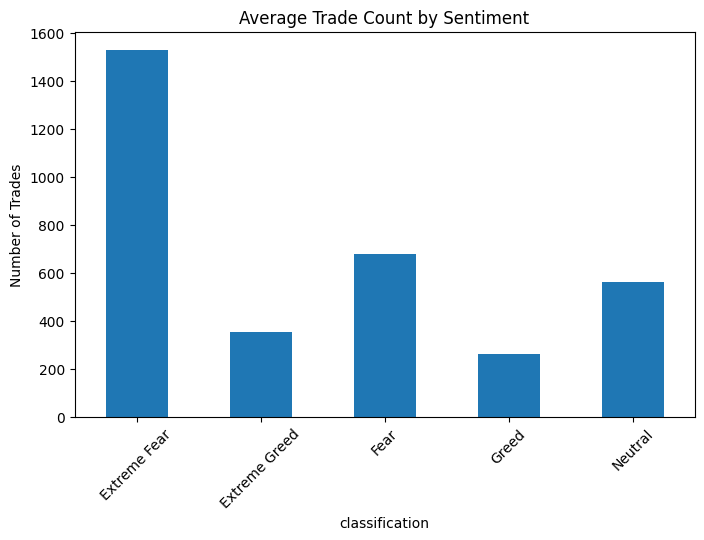

In [95]:
trade_per_day = df.groupby(['date','classification']).size().reset_index(name='num_trades')

trade_per_day.groupby('classification')['num_trades'].mean().plot(kind='bar', figsize=(8,5))
plt.title('Average Trade Count by Sentiment')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)
plt.show()


In [96]:

trade_freq = df.groupby('Account').size()

freq_map = (trade_freq > trade_freq.median()).astype(int)

df['freq_segment'] = df['Account'].map(freq_map)
df['freq_segment'] = df['freq_segment'].map({0:'low_freq',1:'high_freq'})

df['freq_segment'].value_counts()


,count
freq_segment,
high_freq,186957
low_freq,24267


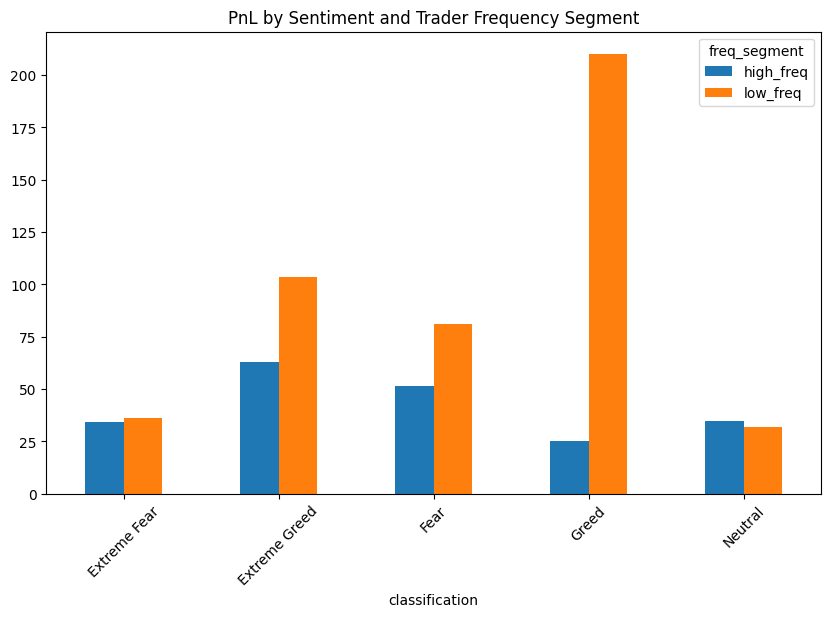

In [97]:
df.groupby(['classification','freq_segment'])['Closed PnL'].mean().unstack().plot(
    kind='bar',
    figsize=(10,6)
)

plt.title('PnL by Sentiment and Trader Frequency Segment')
plt.xticks(rotation=45)
plt.show()


## Strategy Recommendations


## Strategy Idea 1 : Adaptive Risk Based on Market Sentiment

Analysis shows that larger trade-size segments consistently achieve higher average PnL across most sentiment regimes, while smaller trade-size segments underperform during Extreme Fear conditions. This suggests that aggressive risk-taking is more effective during positive sentiment but becomes harmful during market panic.

Proposed Rule:

During Extreme Fear periods, reduce position size and avoid aggressive trading for small or infrequent traders.

During Greed or Extreme Greed, medium and large traders may increase exposure since profitability trends improve.

Expected Benefit:
Adaptive risk management could reduce drawdowns for smaller traders while maximizing upside during bullish sentiment.


## Strategy Idea 2 : Behavior-Based Trading Segmentation

Segment analysis indicates that trader behavior differs across sentiment regimes. Frequent traders maintain relatively stable performance, while low-frequency traders experience higher variability during negative sentiment.

Proposed Rule:

Encourage high-frequency traders to maintain consistent activity regardless of sentiment.

Suggest low-frequency traders reduce trading during Extreme Fear periods to avoid volatility-driven losses.

Expected Benefit:
Segment-aware strategy design helps tailor risk exposure to trader behavior rather than applying a single rule to all accounts.

## Strategy Idea 3 — Sentiment-Aware Trade Sizing

Market sentiment correlates with changes in average trade size. Higher sentiment levels (Greed) are associated with increased trade sizes and higher realized PnL.

Proposed Rule:

Use sentiment classification as a signal to dynamically scale trade size.

Increase average position size gradually during Greed regimes and scale down during Fear regimes.

Expected Benefit:
Dynamic position sizing aligned with sentiment may improve risk-adjusted returns.